<a href="https://colab.research.google.com/github/JasminiSantos/100-Days-of-SwiftUI/blob/main/Projeto_Final_Resid%C3%AAncia_Tecnologias_Aeroespaciais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Anomalias em GPS de Drones Usando Aprendizado de Máquina

O conjunto de dados “A Dataset for GPS Spoofing Detection on Unmanned Aerial System” foi publicado por Aissou e Ghilas (2022) e reúne medições de sinais de navegação GNSS simuladas e reais obtidas em diferentes cenários de voo.
O objetivo é apoiar o desenvolvimento e a avaliação de algoritmos de detecção de GPS spoofing, ataques em que sinais falsos são transmitidos para enganar o receptor do drone.

O receptor GPS disponibiliza 13 atributos técnicos por canal, cada um representando uma etapa específica do processo de aquisição, rastreamento e correlação do sinal GNSS. Esses parâmetros permitem identificar alterações sutis causadas por interferência ou spoofing, pois ataques afetam diretamente potência, correlação, pseudodistância e comportamento Doppler.

PRN - ID do satélite

DO - Desvio Doppler

PD - Variação de pseudodistância

RX - Potência do sinal recebido

TOW - Tempo da semana (GPS)

CP - Correlação da fase da portadora

EC/LC - Correlação adiantada e atrasada

PC - Pseudodistância

PIP/PQP - Correlação prompt (I/Q)

TCD - Atraso do código de rastreamento

CN0 - Razão portadora/ruído (dB-Hz)

**Importa bibliotecas e o dataset**

In [1]:
# Importa bibliotecas
import os, math, json, csv, random, gc, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, cross_val_predict, GridSearchCV, learning_curve
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    average_precision_score, roc_auc_score
)
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os, zipfile

# Dataset obtido em: https://data.mendeley.com/datasets/z7dj3yyzt8/3
ZIP_PATH = "/content/drive/MyDrive/Tecnologias Aeroespaciais/Projeto Final/Dataset/A DATASET for GPS Spoofing Detection on Unmanned Aerial System.zip"
EXTRACT_DIR = "/content/datasets"
DATA_PATH = EXTRACT_DIR + "/A DATASET for GPS Spoofing Detection on Unmanned Aerial System/GPS_Data_Simplified_2D_Feature_Map.xlsx"

os.makedirs(EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(EXTRACT_DIR)

arquivos = []

for root, _, files in os.walk(EXTRACT_DIR):
    for f in files:
        arquivos.append(os.path.join(root, f))

**Configurações gerais**

In [62]:
# Configurações Gerais
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
PREFERRED_COLS = ["PRN","DO","PD","RX","TOW","CP","EC","LC","PC","PIP","PQP","TCD","CN0","label"]
CLASS_NAMES = {
    0: "Autêntico",
    1: "Simples",
    2: "Intermediário",
    3: "Sofisticado",
}
USE_SAMPLE = True
SAMPLE_SIZE = 20_000

In [6]:
# Carregamento de Dados
def load_feature_map_2d(xlsx_path: str = DATA_PATH) -> pd.DataFrame:
    df = pd.read_excel(xlsx_path, engine="openpyxl")
    df.columns = [str(c).strip() for c in df.columns]
    if "label" not in df.columns and "Output" in df.columns:
        df = df.rename(columns={"Output":"label"})
    keep = [c for c in PREFERRED_COLS if c in df.columns]
    df = df[keep].copy()

    for c in df.columns:
        if c != "label":
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if "label" in df.columns:
        df["label"] = pd.to_numeric(df["label"], errors="coerce").fillna(0).astype(int)

    feats = [c for c in df.columns if c != "label"]
    df = df.dropna(subset=feats, how="all").reset_index(drop=True)

    if USE_SAMPLE and len(df) > SAMPLE_SIZE:
        df = df.sample(SAMPLE_SIZE, random_state=SEED).reset_index(drop=True)

    return df

In [7]:
def prepare_Xy(df):
    FEATURES = [c for c in df.columns if c != "label"]
    X = df[FEATURES]
    y = df["label"].astype(int)
    return X, y, FEATURES

In [8]:
def plot_corr_heatmap(
    df,
    label_col="label",
    figsize=(8, 6),
    cmap="Blues",
    title="Mapa de correlação (Spearman)"
):

    corr = df.corr("spearman")

    if label_col in corr.index:
        corr = corr.drop(index=label_col, columns=label_col)

    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        vmin=-1, vmax=1,
        square=True,
        cbar_kws={"shrink": .8}
    )
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

**Análise Exploratória de Dados**

In [73]:
# Gráficos de EDA
def plot_class_balance(df, class_names=CLASS_NAMES):
    if "label" not in df.columns:
        print("Sem label")
        return

    counts = df["label"].value_counts().sort_index()
    labels = counts.index.values
    valores = counts.values

    if class_names is not None:
        x_labels = [class_names.get(int(c), str(c)) for c in labels]
    else:
        x_labels = [str(c) for c in labels]

    x = np.arange(len(labels))

    plt.figure(figsize=(6,4))
    plt.bar(x, valores, align="center")
    plt.xticks(x, x_labels, rotation=0, ha="center")
    plt.title("Balanceamento de classes")
    plt.xlabel("Classe")
    plt.ylabel("Contagem")
    plt.tight_layout()
    plt.show()

In [34]:
def plot_true_classes(X, y, sample_size=20000, random_state=42,
                      class_names=CLASS_NAMES):
    np.random.seed(random_state)

    n = X.shape[0]
    if sample_size < n:
        idx = np.random.choice(n, size=sample_size, replace=False)
        X_plot = X[idx]
        y_plot = y.iloc[idx] if hasattr(y, "iloc") else y[idx]
    else:
        X_plot = X
        y_plot = y

    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X_plot)

    plt.figure(figsize=(7, 6))
    plt.scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        s=3,
        c="lightgray",
        alpha=0.3
    )

    colors = {
        0: "tab:blue",
        1: "tab:orange",
        2: "tab:green",
        3: "tab:red",
    }

    for c in sorted(class_names.keys()):
        mask = (y_plot == c)
        plt.scatter(
            X_pca[mask, 0],
            X_pca[mask, 1],
            s=8,
            c=colors.get(c, "black"),
            alpha=0.7,
            label=class_names[c]
        )

    plt.title("Distribuição PCA — classes verdadeiras")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [35]:
# Importa e prepara o dataset
df = load_feature_map_2d(DATA_PATH)

# Primeiras 5 entradas
df.head()

,PRN,DO,PD,RX,TOW,CP,EC,LC,PC,PIP,PQP,TCD,CN0,label
0,26,-1604.415564,2.507708e+07,174134.74,174134.65640,150686.610800,144572.3281,164237.67190,173516.0156,-172501.01560,18740.49805,-1570.256226,49.151814,0
1,7,3670.747847,4.073525e+06,263429.10,263429.08640,-93352.185870,133020.1406,136807.73440,158899.1563,-158446.84380,-11980.71094,3654.903320,46.558170,0
2,20,2144.433859,6.059595e+06,263715.76,263715.73980,-317230.765500,118241.8438,95528.59375,114252.3516,109960.32030,-31021.39844,2150.026367,40.155594,0
3,27,3278.678535,3.687842e+06,263234.38,263234.36770,-119353.532300,134409.2969,116025.32030,141549.7500,67597.16406,124366.21880,3295.291992,46.294033,0
4,11,3249.461936,4.346173e+05,491669.46,491669.45855,-117807.131089,161819.0900,156342.28000,173476.0600,173463.52000,2086.89430,3334.470500,48.482132,0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRN     20000 non-null  int64  
 1   DO      20000 non-null  float64
 2   PD      20000 non-null  float64
 3   RX      20000 non-null  float64
 4   TOW     20000 non-null  float64
 5   CP      20000 non-null  float64
 6   EC      20000 non-null  float64
 7   LC      20000 non-null  float64
 8   PC      20000 non-null  float64
 9   PIP     20000 non-null  float64
 10  PQP     20000 non-null  float64
 11  TCD     20000 non-null  float64
 12  CN0     20000 non-null  float64
 13  label   20000 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 2.1 MB


In [37]:
df['label'].value_counts().sort_index()

,count
label,
0,15667
1,1381
2,1666
3,1286


In [38]:
print(df.shape)

(20000, 14)


In [39]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PRN,20000.0,1.436155e+01,9.270978e+00,2.000000e+00,7.000000e+00,1.100000e+01,2.600000e+01,3.100000e+01
DO,20000.0,1.276981e+03,2.354540e+03,-4.260373e+03,-8.683653e+02,1.350638e+03,3.435139e+03,6.670326e+03
PD,20000.0,8.002177e+06,1.007296e+07,-6.588376e+06,2.403389e+06,3.758836e+06,6.827759e+06,2.830756e+07
RX,20000.0,2.830157e+05,1.070857e+05,1.736400e+05,1.742233e+05,2.633471e+05,2.638061e+05,4.920394e+05
TOW,20000.0,2.830156e+05,1.070856e+05,1.736400e+05,1.742232e+05,2.633471e+05,2.638061e+05,4.920393e+05
CP,20000.0,-1.187927e+05,2.376712e+05,-1.030807e+06,-2.517458e+05,-9.534693e+04,6.414684e+04,3.527989e+05
EC,20000.0,1.082401e+05,3.164763e+04,1.096622e+03,8.662976e+04,1.103982e+05,1.312268e+05,2.077211e+05
LC,20000.0,1.081232e+05,3.152136e+04,1.479235e+03,8.648781e+04,1.101162e+05,1.312135e+05,2.058859e+05
PC,20000.0,1.198414e+05,3.407356e+04,1.264938e+03,9.668375e+04,1.224737e+05,1.447856e+05,2.213742e+05
PIP,20000.0,-8.010212e+02,1.224238e+05,-2.204317e+05,-1.207437e+05,-1.497470e+04,1.199417e+05,2.209195e+05


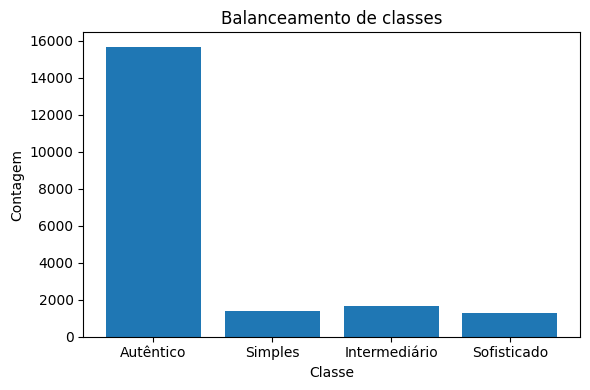

In [74]:
plot_class_balance(df)

In [41]:
df.isnull().sum()

,0
PRN,0
DO,0
PD,0
RX,0
TOW,0
CP,0
EC,0
LC,0
PC,0
PIP,0


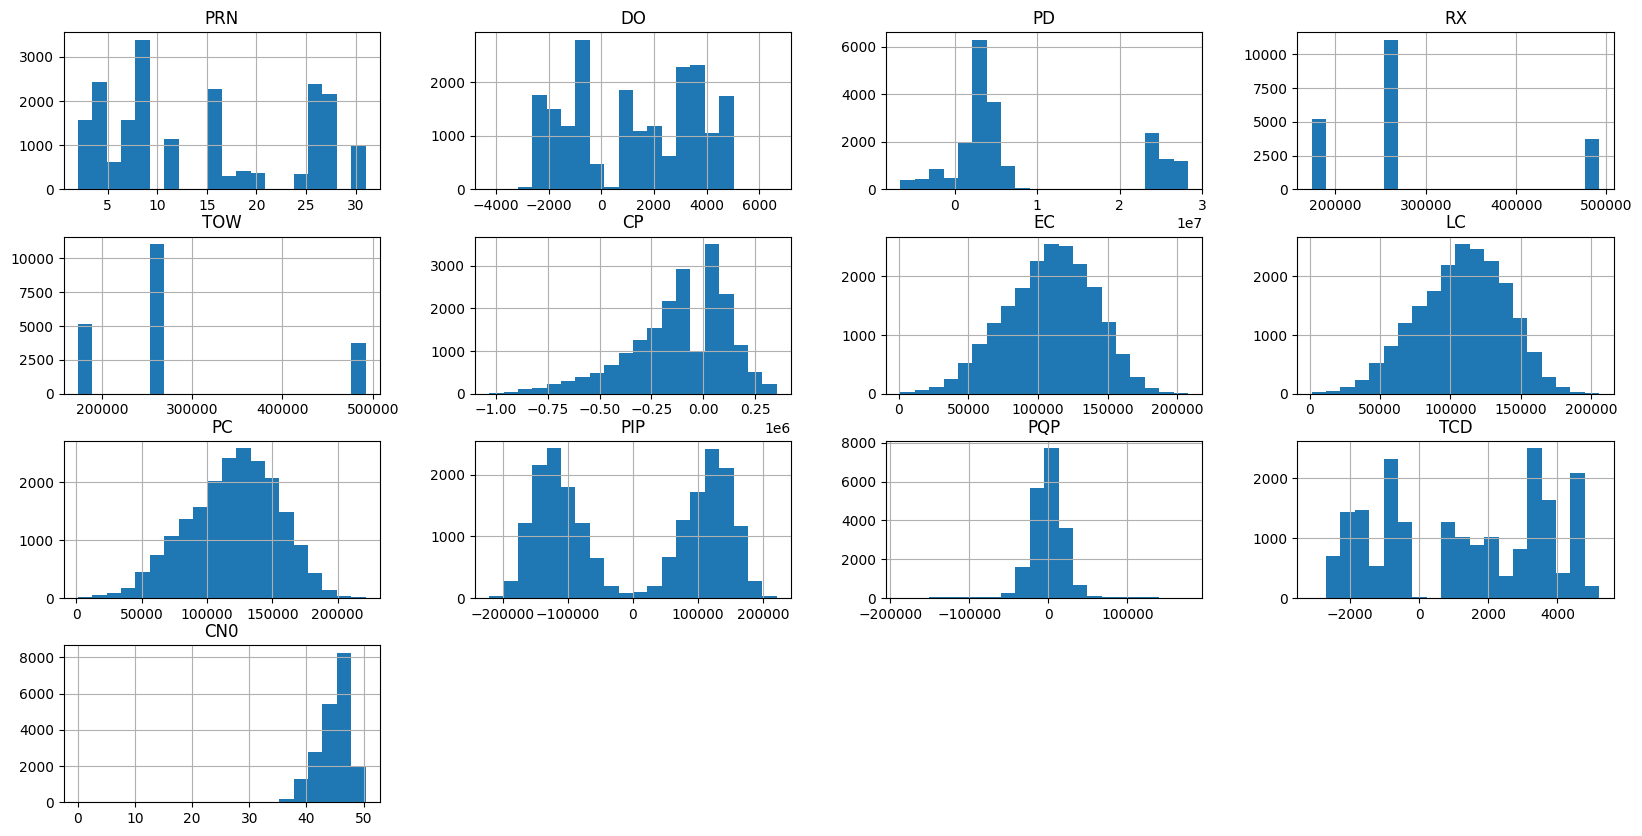

In [42]:
# Mostra os histogramas com todas as variáveis
sample_z = df.drop(columns='label')
sample_z.hist(bins = 20, figsize =(20, 10))
plt.show()

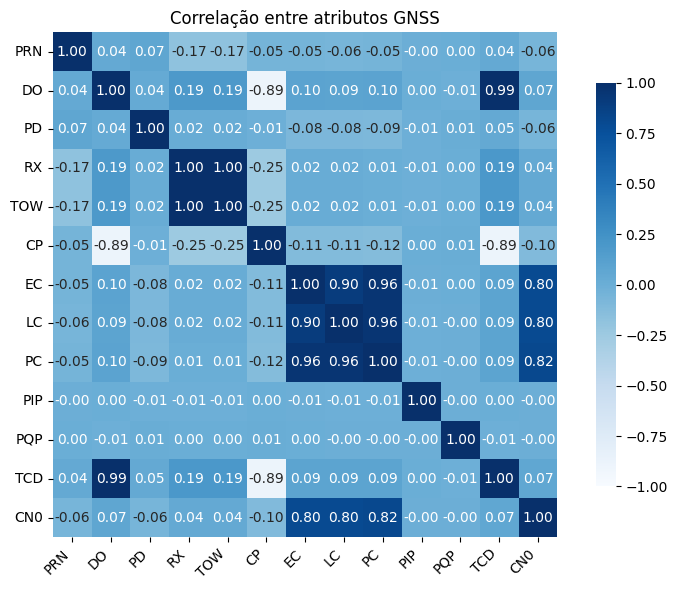

In [43]:
plot_corr_heatmap(df, label_col="label", title="Correlação entre atributos GNSS")

In [44]:
df_proc = df.copy(deep=True)

# Seleciona as três features redundantes
redundant = df_proc[["EC", "LC", "PC"]]

# Aplica PCA
pca = PCA(n_components=1)
pca_component = pca.fit_transform(redundant)
print(pca.explained_variance_ratio_)

# Adiciona como nova coluna na tabela tratada
df_proc["EC_LC_PC_PCA"] = pca_component
df_proc = df_proc.drop(columns=["EC", "LC", "PC"])
df_proc = df_proc.drop(columns=["TOW", "TCD"])

df_proc.head()

[0.96237048]


,PRN,DO,PD,RX,CP,PIP,PQP,CN0,label,EC_LC_PC_PCA
0,26,-1604.415564,2.507708e+07,174134.74,150686.610800,-172501.01560,18740.49805,49.151814,0,84531.681381
1,7,3670.747847,4.073525e+06,263429.10,-93352.185870,-158446.84380,-11980.71094,46.558170,0,53820.351827
2,20,2144.433859,6.059595e+06,263715.76,-317230.765500,109960.32030,-31021.39844,40.155594,0,-4854.989479
3,27,3278.678535,3.687842e+06,263234.38,-119353.532300,67597.16406,124366.21880,46.294033,0,32366.425195
4,11,3249.461936,4.346173e+05,491669.46,-117807.131089,173463.52000,2086.89430,48.482132,0,89752.641286


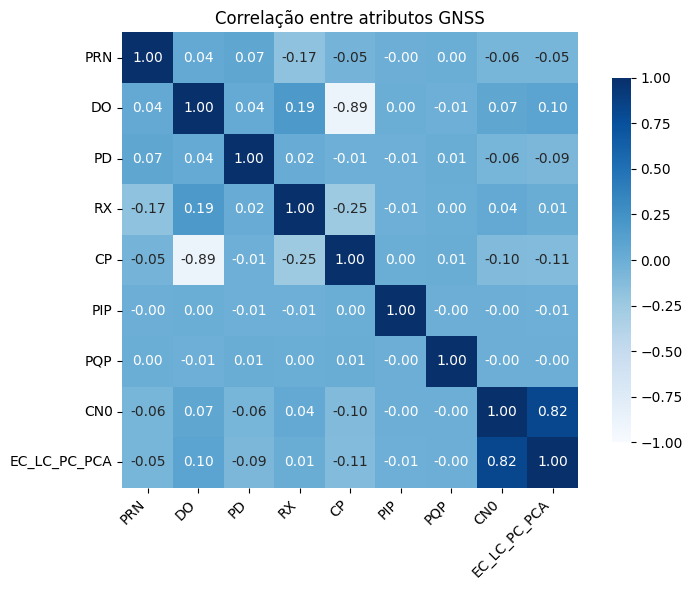

In [45]:
plot_corr_heatmap(df_proc, label_col="label", title="Correlação entre atributos GNSS")

In [46]:
X, y, FEATURES = prepare_Xy(df_proc)

In [47]:
# Normalização das features usando StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [48]:
# Divisão dos dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=SEED, stratify=y)

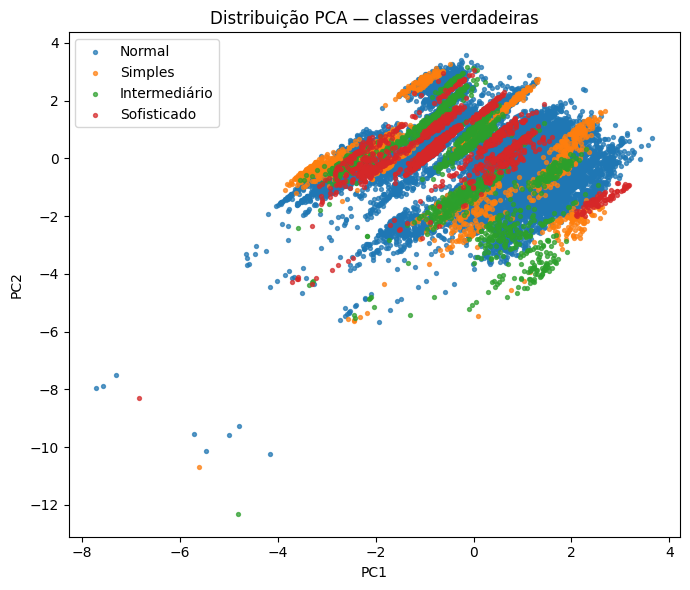

In [114]:
plot_true_classes(X_scaled, y)

### DBSCAN

In [50]:
def plot_k_distance(X, min_samples_k):
    neigh = NearestNeighbors(n_neighbors=min_samples_k)
    distances, indices = neigh.fit(X).kneighbors(X)

    k_distance = distances[:, min_samples_k - 1]

    k_distance.sort()

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(k_distance)), k_distance, marker='o', markersize=2, linestyle='-')

    plt.title(f"Gráfico de k-Distância (k = {min_samples_k})")
    plt.xlabel("Pontos de dados (Ordenados por Distância)")
    plt.ylabel(f"Distância para o {min_samples_k}-ésimo vizinho mais próximo")
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.show()

In [51]:
def run_dbscan(X, eps=0.8, min_samples=20, n_jobs=-1):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=n_jobs)
    dbscan.fit(X)

    labels = dbscan.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = np.sum(labels == -1)

    print(f"Clusters encontrados: {n_clusters_}")
    print(f"Pontos marcados como ruído/anomalia: {n_noise_}")

    return dbscan, labels, n_clusters_, n_noise_

In [71]:
def plot_dbscan_anomalies(
    X,
    labels,
    sample_size=20000,
    random_state=42,
    title_prefix="DBSCAN"
):
    np.random.seed(random_state)

    n = X.shape[0]
    if sample_size < n:
        idx = np.random.choice(n, size=sample_size, replace=False)
        X_plot = X[idx]
        labels_plot = labels[idx]
    else:
        X_plot = X
        labels_plot = labels

    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X_plot)

    mask_anom = (labels_plot == -1)
    mask_norm = ~mask_anom

    n_noise_ = np.sum(labels == -1)

    plt.figure(figsize=(7, 6))

    plt.scatter(
        X_pca[mask_norm, 0],
        X_pca[mask_norm, 1],
        s=5,
        c="lightgray",
        alpha=0.5,
        label="Pontos normais"
    )

    plt.scatter(
        X_pca[mask_anom, 0],
        X_pca[mask_anom, 1],
        s=12,
        c="red",
        alpha=0.9,
        label="Anomalias"
    )

    plt.title(f"{title_prefix}\nAnomalias detectadas: {n_noise_}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()

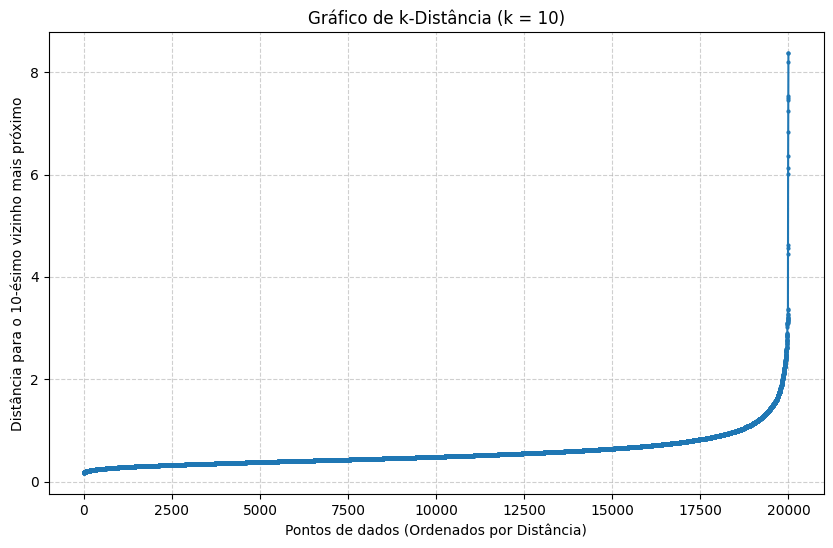

In [53]:
plot_k_distance(X_scaled, min_samples_k=10)

Clusters encontrados: 41
Pontos marcados como ruído/anomalia: 716


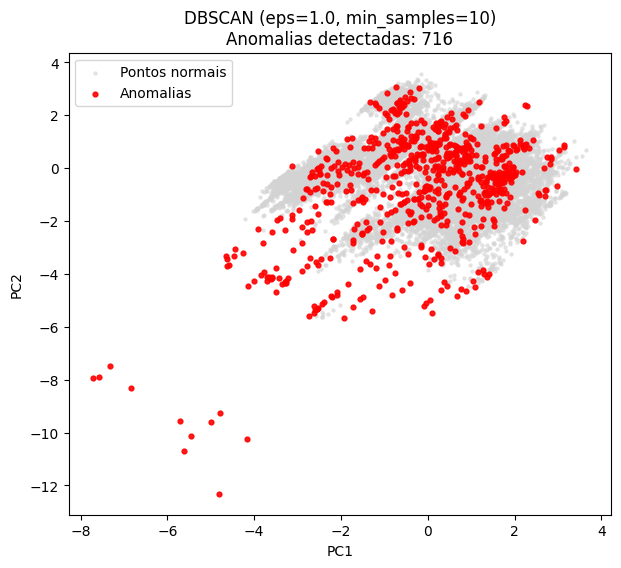

In [115]:
# roda o DBSCAN
eps = 1.0
min_samples = 10
sample_size = 20000

dbscan, labels, n_clusters, n_noise = run_dbscan(
    X_scaled,
    eps=eps,
    min_samples=min_samples
)

# plota as anomalias com PCA 2D
plot_dbscan_anomalies(
    X_scaled,
    labels,
    sample_size=sample_size,
    random_state=SEED,
    title_prefix=f"DBSCAN (eps={eps}, min_samples={min_samples})"
)

# Supervisionado

In [144]:
def plot_confusion_matrix(y_true, y_pred, model_name="", class_names=CLASS_NAMES):
    cm = confusion_matrix(y_true, y_pred)

    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    labels_idx = sorted(class_names.keys())
    tick_labels = [class_names[i] for i in labels_idx]

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=tick_labels,
        yticklabels=tick_labels
    )
    plt.title(f"Matriz de confusão — {model_name}")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.tight_layout()
    plt.show()


def plot_feature_importance_tree(model, feature_names, top_n=15, title=None):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]

    plt.figure(figsize=(7, 0.4 * top_n + 1))
    sns.barplot(
        x=importances[indices],
        y=np.array(feature_names)[indices],
        orient="h"
    )
    plt.xlabel("Importância")
    plt.ylabel("Atributo")
    if title is None:
        title = "Importância das features (árvore)"
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_model_comparison(metrics_dict, metric="f1_macro"):
    items = [(model, metrics_dict[model][metric]) for model in metrics_dict]

    items_sorted = sorted(items, key=lambda x: x[1], reverse=True)

    model_names = [item[0] for item in items_sorted]
    values = [item[1] for item in items_sorted]

    plt.figure(figsize=(7, 4))
    sns.barplot(x=model_names, y=values)
    plt.ylabel(metric)
    plt.ylim(0, 1.0)
    plt.title(f"Comparação de modelos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()



def plot_pca_2d(X, y, class_names, title="Projeção PCA (2 componentes)"):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(6, 5))
    for cls_idx, cls_name in enumerate(class_names):
        mask = (y == cls_idx)
        plt.scatter(
            X_pca[mask, 0],
            X_pca[mask, 1],
            label=cls_name,
            alpha=0.5,
            s=10
        )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [55]:
def plot_learning_curve(
    estimator,
    X,
    y,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring="f1_macro",
    title="Curva de aprendizado"
):
    train_sizes_abs, train_scores, val_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        cv=cv,
        train_sizes=train_sizes,
        scoring=scoring,
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    plt.figure(figsize=(6, 4))

    # curva de treino
    plt.plot(train_sizes_abs, train_mean, marker="o", label="Treino")
    plt.fill_between(
        train_sizes_abs,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.1
    )
    # curva de validação
    plt.plot(train_sizes_abs, val_mean, marker="s", label="Validação")
    plt.fill_between(
        train_sizes_abs,
        val_mean - val_std,
        val_mean + val_std,
        alpha=0.1
    )

    plt.xlabel("Número de amostras de treinamento")
    plt.ylabel(scoring)
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    plt.tight_layout()
    plt.show()

In [88]:
def treinar_avaliar_modelo(
    nome,
    base_estimator,
    param_grid,
    X_train,
    y_train,
    X_test,
    y_test,
    class_names=CLASS_NAMES,
    seed=SEED
):
    print(f"\n=== {nome} (GridSearchCV) ===")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    scoring = {
        "accuracy": "accuracy",
        "f1_macro": "f1_macro",
        "f1_weighted": "f1_weighted",
    }

    grid = GridSearchCV(
        estimator=base_estimator,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        refit="f1_macro",
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    print("\nMelhores hiperparâmetros encontrados:")
    print(grid.best_params_)

    best_idx = grid.best_index_
    cv_results = grid.cv_results_

    cv_acc_mean = cv_results["mean_test_accuracy"][best_idx]
    cv_acc_std  = cv_results["std_test_accuracy"][best_idx]
    cv_f1m_mean = cv_results["mean_test_f1_macro"][best_idx]
    cv_f1m_std  = cv_results["std_test_f1_macro"][best_idx]
    cv_f1w_mean = cv_results["mean_test_f1_weighted"][best_idx]
    cv_f1w_std  = cv_results["std_test_f1_weighted"][best_idx]

    print("\nResultados da validação cruzada (melhor conjunto de parâmetros):")
    print(f"CV Accuracy média:    {cv_acc_mean:.4f} +/- {cv_acc_std:.4f}")
    print(f"CV F1-macro médio:    {cv_f1m_mean:.4f} +/- {cv_f1m_std:.4f}")
    print(f"CV F1-weighted médio: {cv_f1w_mean:.4f} +/- {cv_f1w_std:.4f}")

    # Melhor modelo já vem treinado no treino inteiro
    best_model = grid.best_estimator_

    # Avaliação no teste
    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    print("\nAvaliação no conjunto de teste:")
    print("Matriz de confusão (valores absolutos):")
    print(confusion_matrix(y_test, y_pred))
    print("\nRelatório de classificação:")
    print(classification_report(y_test, y_pred))

    print(f"Test Accuracy:    {acc:.4f}")
    print(f"Test F1-macro:    {f1_macro:.4f}")
    print(f"Test F1-weighted: {f1_weighted:.4f}")

    # Gráfico da matriz de confusão
    plot_confusion_matrix(
        y_test,
        y_pred,
        class_names=class_names,
        model_name=f"Matriz de confusão — {nome}"
    )

    metrics = {
        "cv_accuracy_mean": cv_acc_mean,
        "cv_f1_macro_mean": cv_f1m_mean,
        "cv_f1_weighted_mean": cv_f1w_mean,
        "test_accuracy": acc,
        "test_f1_macro": f1_macro,
        "test_f1_weighted": f1_weighted,
        "best_params": grid.best_params_,
    }

    return best_model, metrics


### Random Forest


=== RandomForestClassifier (GridSearchCV) ===
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Melhores hiperparâmetros encontrados:
{'max_depth': 15, 'max_features': 8, 'min_samples_leaf': 2, 'n_estimators': 100}

Resultados da validação cruzada (melhor conjunto de parâmetros):
CV Accuracy média:    0.9354 +/- 0.0037
CV F1-macro médio:    0.8745 +/- 0.0052
CV F1-weighted médio: 0.9384 +/- 0.0032

Avaliação no conjunto de teste:
Matriz de confusão (valores absolutos):
[[2975   48  101   10]
 [  14  241   21    0]
 [  14   29  290    0]
 [   5    0    0  252]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3134
           1       0.76      0.87      0.81       276
           2       0.70      0.87      0.78       333
           3       0.96      0.98      0.97       257

    accuracy                           0.94      4000
   macro avg       0.85      0.92      0.88      4000
weighted a

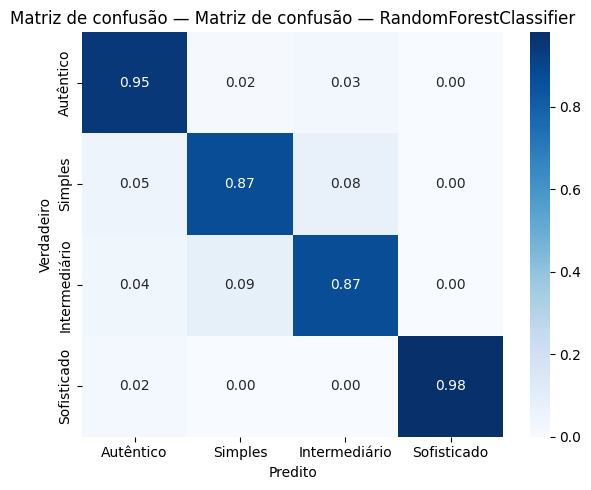

In [122]:
rf = RandomForestClassifier(
    class_weight="balanced",
    n_jobs=-1,
    random_state=SEED
)
rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15],
    "max_features": [8, 10, 12],
    "min_samples_leaf": [1, 2],
}

rf_model, rf_metrics = treinar_avaliar_modelo(
    "RandomForestClassifier",
    rf,
    rf_param_grid,
    X_train,
    y_train,
    X_test,
    y_test
)

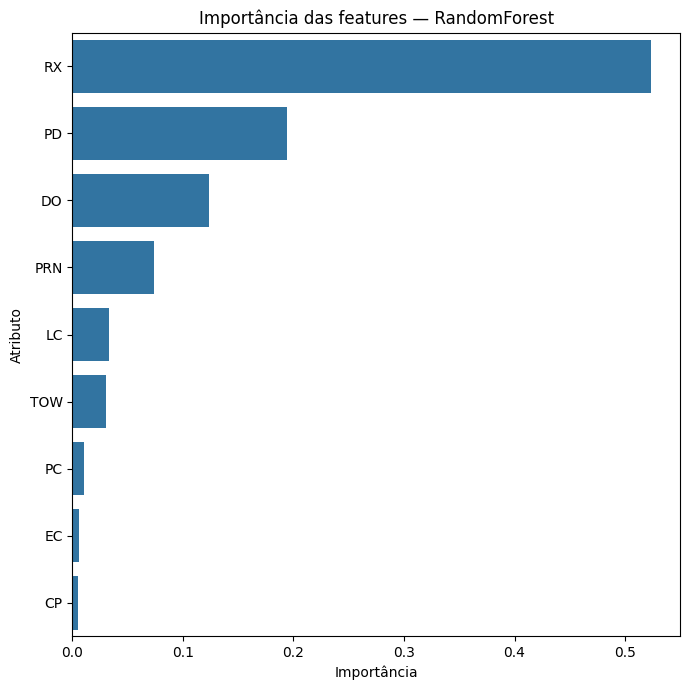

In [60]:
plot_feature_importance_tree(
    model=rf_model,
    feature_names= df.drop(columns=["label"]).columns,
    top_n=15,
    title="Importância das features — RandomForest"
)

**Logistic Regression**


=== LogisticRegression (GridSearchCV) ===
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Melhores hiperparâmetros encontrados:
{'C': 0.1}

Resultados da validação cruzada (melhor conjunto de parâmetros):
CV Accuracy média:    0.3566 +/- 0.0060
CV F1-macro médio:    0.2768 +/- 0.0025
CV F1-weighted médio: 0.4262 +/- 0.0078

Avaliação no conjunto de teste:
Matriz de confusão (valores absolutos):
[[1061  596  478  999]
 [  75   90   49   62]
 [  13   73  138  109]
 [  20   33   48  156]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.91      0.34      0.49      3134
           1       0.11      0.33      0.17       276
           2       0.19      0.41      0.26       333
           3       0.12      0.61      0.20       257

    accuracy                           0.36      4000
   macro avg       0.33      0.42      0.28      4000
weighted avg       0.74      0.36      0.43      4000

Test Accuracy:    0.3613
Test F1-macro:    0.2807
Test F1-weighted: 0.4326


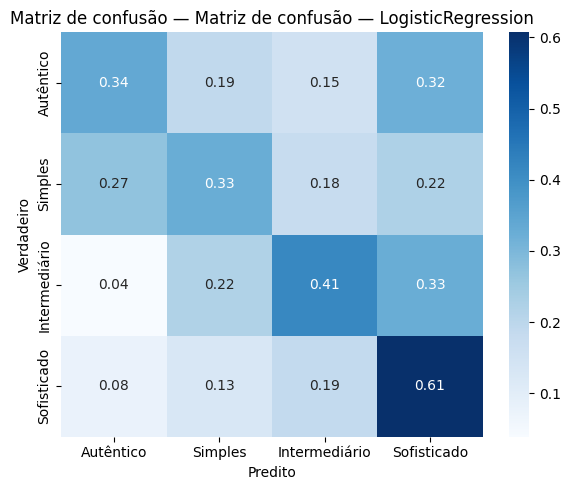

In [124]:
lr = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    multi_class="multinomial",
    class_weight="balanced",
    max_iter=1000,
    random_state=SEED
)


lr_param_grid = {
    "C": [0.1, 1.0, 10.0],
}

lr_model, lr_metrics = treinar_avaliar_modelo(
    "LogisticRegression",
    lr,
    lr_param_grid,
    X_train,
    y_train,
    X_test,
    y_test
)


=== KNN (GridSearchCV) ===
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Melhores hiperparâmetros encontrados:
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

Resultados da validação cruzada (melhor conjunto de parâmetros):
CV Accuracy média:    0.8526 +/- 0.0035
CV F1-macro médio:    0.6719 +/- 0.0050
CV F1-weighted médio: 0.8468 +/- 0.0028

Avaliação no conjunto de teste:
Matriz de confusão (valores absolutos):
[[2960   48   87   39]
 [  77  173   22    4]
 [ 115   32  186    0]
 [ 107    2    1  147]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      3134
           1       0.68      0.63      0.65       276
           2       0.63      0.56      0.59       333
           3       0.77      0.57      0.66       257

    accuracy                           0.87      4000
   macro avg       0.75      0.68      0.71      4000
weighted avg       0.86      0.87      0.86      4000

Test Ac

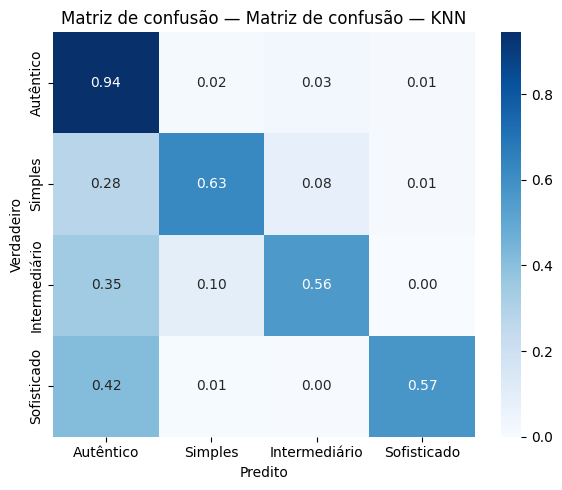

In [95]:
knn = KNeighborsClassifier(
    n_jobs=-1
)

knn_param_grid = {
    "n_neighbors": [3, 5, 11, 21],
    "weights": ["uniform", "distance"],
    "p": [1, 2],
}

knn_model, knn_metrics = treinar_avaliar_modelo(
    "KNN",
    knn,
    knn_param_grid,
    X_train,
    y_train,
    X_test,
    y_test
)


=== NaiveBayes (GridSearchCV) ===
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Melhores hiperparâmetros encontrados:
{'var_smoothing': np.float64(0.0004328761281083057)}

Resultados da validação cruzada (melhor conjunto de parâmetros):
CV Accuracy média:    0.7597 +/- 0.0029
CV F1-macro médio:    0.2798 +/- 0.0067
CV F1-weighted médio: 0.6953 +/- 0.0029

Avaliação no conjunto de teste:
Matriz de confusão (valores absolutos):
[[2999  115    0   20]
 [ 213   53    0   10]
 [ 300   33    0    0]
 [ 233    3    0   21]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      3134
           1       0.26      0.19      0.22       276
           2       0.00      0.00      0.00       333
           3       0.41      0.08      0.14       257

    accuracy                           0.77      4000
   macro avg       0.37      0.31      0.31      4000
weighted avg       0.67      0.77      0.71      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


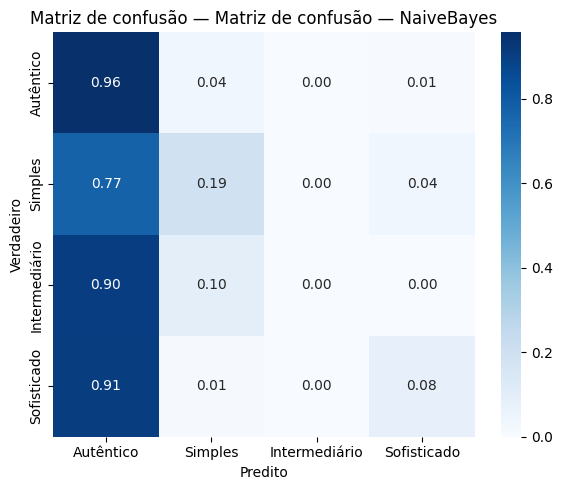

In [90]:
nb = GaussianNB()

nb_param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nb_model, nb_metrics = treinar_avaliar_modelo(
    "NaiveBayes",
    nb,
    nb_param_grid,
    X_train,
    y_train,
    X_test,
    y_test
)


=== DecisionTree (GridSearchCV) ===
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Melhores hiperparâmetros encontrados:
{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 2}

Resultados da validação cruzada (melhor conjunto de parâmetros):
CV Accuracy média:    0.9354 +/- 0.0024
CV F1-macro médio:    0.8762 +/- 0.0044
CV F1-weighted médio: 0.9387 +/- 0.0023

Avaliação no conjunto de teste:
Matriz de confusão (valores absolutos):
[[2959   54  108   13]
 [  10  245   21    0]
 [  10   35  288    0]
 [   2    0    0  255]]

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      3134
           1       0.73      0.89      0.80       276
           2       0.69      0.86      0.77       333
           3       0.95      0.99      0.97       257

    accuracy                           0.94      4000
   macro avg       0.84      0.92      0.88      4000
weighted avg

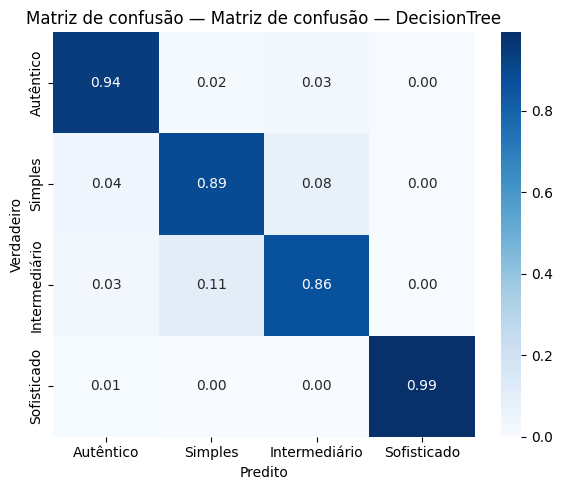

In [112]:
dt = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=SEED
)

dt_param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 15, 20],
    "min_samples_split": [2, 10, 50],
    "min_samples_leaf": [1, 5, 20],
}

dt_model, dt_metrics = treinar_avaliar_modelo(
    "DecisionTree",
    dt,
    dt_param_grid,
    X_train,
    y_train,
    X_test,
    y_test
)

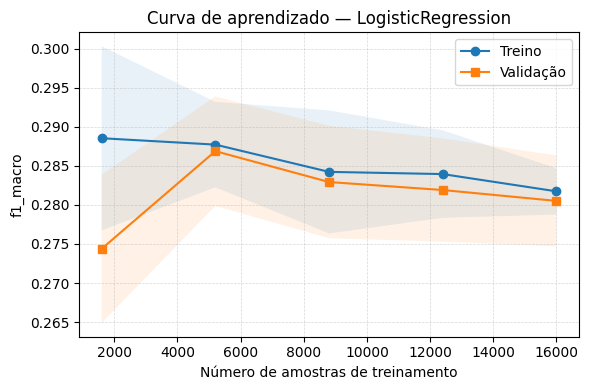

In [149]:
plot_learning_curve(
    lr_model,
    X_scaled,
    y,
    cv=5,
    scoring="f1_macro",
    title="Curva de aprendizado — LogisticRegression"
)

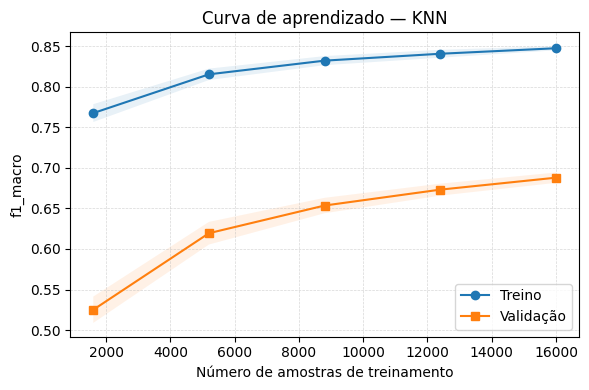

In [153]:
plot_learning_curve(
    knn_model,
    X_scaled,
    y,
    cv=5,
    scoring="f1_macro",
    title="Curva de aprendizado — KNN"
)

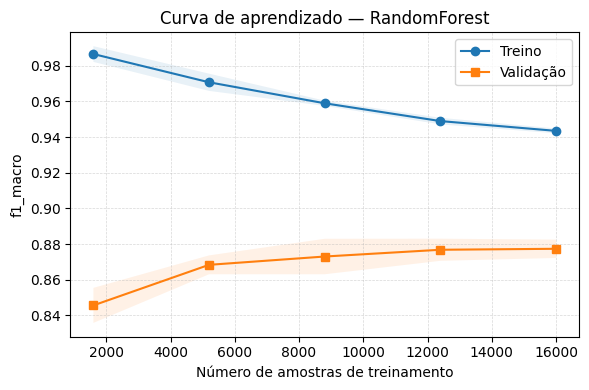

In [154]:
plot_learning_curve(
    rf_model,
    X_scaled,
    y,
    cv=5,
    scoring="f1_macro",
    title="Curva de aprendizado — RandomForest"
)

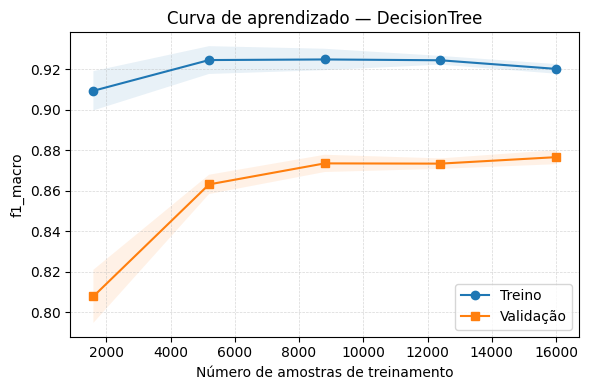

In [148]:
plot_learning_curve(
    dt_model,
    X_scaled,
    y,
    cv=5,
    scoring="f1_macro",
    title="Curva de aprendizado — DecisionTree"
)

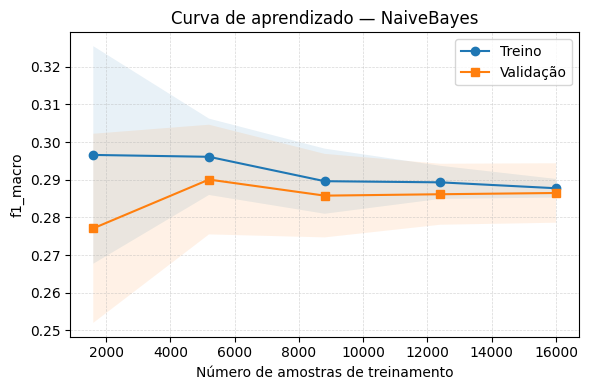

In [147]:
plot_learning_curve(
    nb_model,
    X_scaled,
    y,
    cv=5,
    scoring="f1_macro",
    title="Curva de aprendizado — NaiveBayes"
)

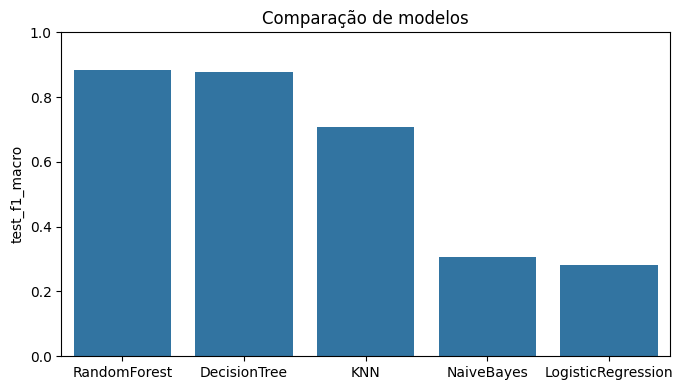

In [156]:
model_metrics = {
    "RandomForest": rf_metrics,
    "LogisticRegression": lr_metrics,
    "KNN": knn_metrics,
    "DecisionTree": dt_metrics,
    "NaiveBayes": nb_metrics
}

plot_model_comparison(model_metrics, metric="test_f1_macro")

In [157]:
def build_metrics_table(metrics_dict):
    rows = []
    for model_name, metrics in metrics_dict.items():
        rows.append({
            "Modelo": model_name,
            "Accuracy (teste)": metrics.get("test_accuracy", None),
            "F1-macro (teste)": metrics.get("test_f1_macro", None),
            "F1-weighted (teste)": metrics.get("test_f1_weighted", None),
        })

    df = pd.DataFrame(rows)
    df = df.sort_values(by="F1-macro (teste)", ascending=False).reset_index(drop=True)
    return df

tabela_modelos = build_metrics_table(model_metrics)
tabela_modelos

,Modelo,Accuracy (teste),F1-macro (teste),F1-weighted (teste)
0,RandomForest,0.93950,0.882452,0.942203
1,DecisionTree,0.93675,0.877623,0.940035
2,KNN,0.86650,0.706687,0.861985
3,NaiveBayes,0.76825,0.307282,0.707155
4,LogisticRegression,0.36125,0.280660,0.432638


In [161]:
print(tabela_modelos.to_markdown(index=False, floatfmt=".4f"))

| Modelo             |   Accuracy (teste) |   F1-macro (teste) |   F1-weighted (teste) |
|:-------------------|-------------------:|-------------------:|----------------------:|
| RandomForest       |             0.9395 |             0.8825 |                0.9422 |
| DecisionTree       |             0.9367 |             0.8776 |                0.9400 |
| KNN                |             0.8665 |             0.7067 |                0.8620 |
| NaiveBayes         |             0.7682 |             0.3073 |                0.7072 |
| LogisticRegression |             0.3613 |             0.2807 |                0.4326 |
